In [1]:
import os
import sys
from lxml import etree
from urllib.request import urlopen
import numpy as np
from decimal import *
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
# read WCS output as XML string
# parameters are:
"""
SERVICE     = WCS
VERSION     = 2.0.1
REQUEST     = GetCoverage
COVERAGEID  = AverageTemperature
SUBSET      = Lat(-44,-9)
SUBSET      = Long(112,156)
RANGESUBSET = Red # this results a Grayscale image, if left out it returns all bands
FORMAT      = application/gml+xml

"""

full_url = r'http://172.16.12.144:8080/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID=AverageTemperature&SUBSET=Lat(-44,-9)&SUBSET=Long(112,156)&FORMAT=application/gml+xml'
with urlopen(full_url) as url:
    f = url.read()    
root = etree.fromstring(f)

In [3]:
# read GridEnvelope of domainSet and load as numpy array
# shape is + 1 as it starts from 0

low_env  = np.array([int(x) for x in root[1][0][0][0][0].text.split(' ')])
high_env = np.array([int(x) for x in root[1][0][0][0][1].text.split(' ')])
ts_shape = high_env - low_env 

# set the easting, northing and time dimensions

easting  = ts_shape[0]  # why nothing?
northing = ts_shape[1] - 1 # why - 1?
time     = ts_shape[2] + 1 # I get the + 1! I think?

In [4]:
print (r'high_env: ',high_env, r'low_env: ',low_env)
print (r'ts_shape: ',ts_shape)
print (r'easting: ', easting)
print (r'northing: ', northing)
print (r'time: ', time)

high_env:  [840 335   3] low_env:  [730 247   0]
ts_shape:  [110  88   3]
easting:  110
northing:  87
time:  4


In [5]:
# extract the values we need from the parsed XML in Decimal type 
# as there can be many digits after the comma

sta_date_ansi = [Decimal(x) for x in root[0][0][0].text.split(' ')][2] # 150116 
end_date_ansi = [Decimal(x) for x in root[0][0][1].text.split(' ')][2]
sta_date_rasd = [Decimal(x) for x in root[1][0][0][0][0].text.split(' ')][2]
end_date_rasd = [Decimal(x) for x in root[1][0][0][0][1].text.split(' ')][2]
timestep_date = [Decimal(x) for x in root[1][0][5].text.split(' ')][2] 

In [6]:
print (r'sta_date_ansi: ',sta_date_ansi)
print (r'end_date_ansi: ',end_date_ansi)
print (r'sta_date_rasd: ',sta_date_rasd)
print (r'end_date_rasd: ',end_date_rasd)
print (r'timestep_date: ',timestep_date)

sta_date_ansi:  150450.838200231478435077667236328125
end_date_ansi:  150458.866116898158435077667236328125
sta_date_rasd:  0
end_date_rasd:  3
timestep_date:  2.00697916667


In [7]:
# compute the start and end-date based on ansi values
# first get start ansi date minus low time value of GridEnvelope (only have seen 0 values)
# second is number of steps in rasdaman array, starts from 0 so add 1
# end date is no of steps * stepsize + start ansi date

dif_date_anra = sta_date_ansi - sta_date_rasd
dif_date_rasd = end_date_rasd - sta_date_rasd + 1
end_date_anra = dif_date_rasd * timestep_date + dif_date_anra

In [8]:
# concvert ANSI dates to ISO 8601 dates
# start time based on lowerCorner Envelope ansi data
# end time based on solely upperCorner Envelope ansi date
# end time based on lowerCorner ansi date and internal rsd array and step size

sd   = datetime.fromtimestamp((sta_date_ansi - (datetime(1970,1,1) - datetime(1601,1,1)).days) * 24 * 60 * 60)
ed   = datetime.fromtimestamp((end_date_ansi - (datetime(1970,1,1) - datetime(1601,1,1)).days) * 24 * 60 * 60)
ed_1 = datetime.fromtimestamp((end_date_anra - (datetime(1970,1,1) - datetime(1601,1,1)).days) * 24 * 60 * 60)  

In [9]:
# test end dates in ANSI and ISO 8601 format
try:
    assert ed == ed_1
    print (' end dates are equal in ISO 8601 format', ed, ed_1)
except:
    print (' end dates are not equal in ISO 8601 format', ed, ed_1)

try:
    assert end_date_ansi == end_date_anra
    print (' end dates are equal in ANSI format', end_date_ansi, end_date_anra)
except:
    print (' end dates are not equal in ANSI format', end_date_ansi, end_date_anra)  

 end dates are equal in ISO 8601 format 2012-12-10 21:47:12.500001 2012-12-10 21:47:12.500001
 end dates are not equal in ANSI format 150458.866116898158435077667236328125 150458.8661168981584350776672


In [10]:
# convert ISO dates to pandas fixed frequency datetime index

dates = pd.date_range(sd, ed, freq=timedelta(float(timestep_date)))
dates = dates[:-1]
print (dates)

DatetimeIndex(['2012-12-02 21:07:00.500000', '2012-12-04 21:17:03.500000',
               '2012-12-06 21:27:06.500000', '2012-12-08 21:37:09.500000'],
              dtype='datetime64[ns]', freq='173403S')


northing:  87
easting:  110
time:  4
bands:  3
__________________________
2012-12-02 21:07:00.500000


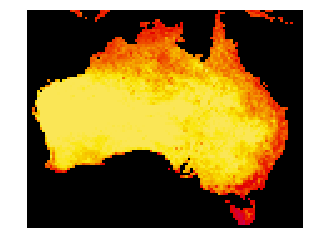

__________________________
2012-12-04 21:17:03.500000


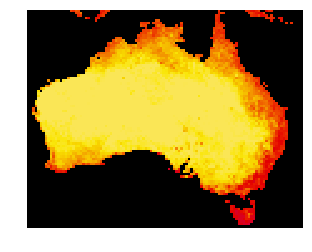

__________________________
2012-12-06 21:27:06.500000


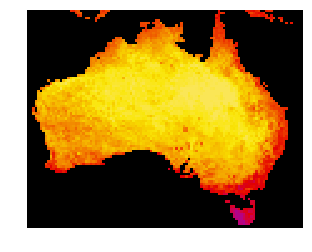

__________________________
2012-12-08 21:37:09.500000


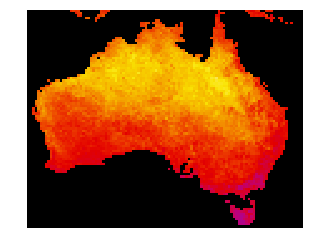

In [11]:
# get tupleList from the DataBlock defined under the rangeSet as 1d numpy array
ts = np.asarray([x.split(' ') for x in root[2][0][1].text.split(',')], dtype='uint8', order='F')

# number of bands
bands = ts.shape[1]

# reshape array using the defined easting, northing and time and bands dimension
# since it is column-major order (?), swap the easting and northing axis to get C-style row-major order
# correct shape is E-N-T-B order
ts_reshape = ts.reshape(easting,northing,time,bands) 
ts_swapaxes = np.swapaxes(ts_reshape,0,1)

# test what happens if N-E-T-B order
#ts_reshape = ts.reshape(northing,easting,time,bands) # if reshape with N-E order see what happens
#ts_swapaxes = ts_reshape # if not swap, see what happens

print ('northing: ', ts_swapaxes.shape[0])
print ('easting: ', ts_swapaxes.shape[1])
print ('time: ', ts_swapaxes.shape[2])
print ('bands: ', ts_swapaxes.shape[3])

# plot image as GRAYSCALE
if bands == 1: 
    for timeslice in range(time):
        print ( '__________________________' )
        print ( dates[timeslice] )
        slice_tx = ts_swapaxes[:,:,timeslice,0]
        plt.axis("off")
        plt.imshow(slice_tx)
        plt.show()    
        
# plot image as RGB        
if bands == 3: 
    for timeslice in range(time):
        print ( '__________________________' )
        print ( dates[timeslice] )        
        slice_tx = ts_swapaxes[:,:,timeslice,:]
        plt.axis("off")
        plt.imshow(slice_tx)
        plt.show()    

northing:  87
easting:  110
time:  4
bands:  3
__________________________
2012-12-02 21:07:00.500000


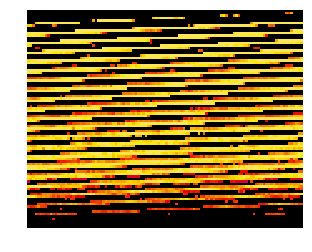

__________________________
2012-12-04 21:17:03.500000


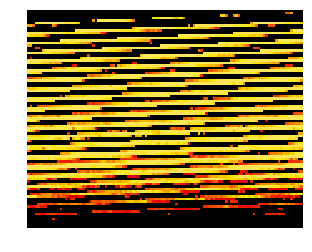

__________________________
2012-12-06 21:27:06.500000


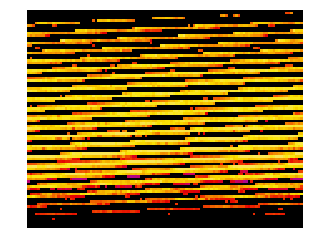

__________________________
2012-12-08 21:37:09.500000


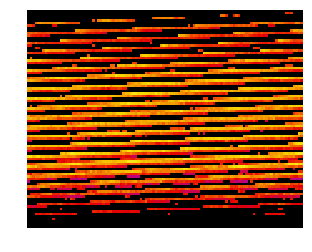

In [12]:
# get tupleList from the DataBlock defined under the rangeSet as 1d numpy array
ts = np.asarray([x.split(' ') for x in root[2][0][1].text.split(',')], dtype='uint8', order='F')

# number of bands
bands = ts.shape[1]

# reshape array using the defined easting, northing and time and bands dimension
# since it is column-major order (?), swap the easting and northing axis to get C-style row-major order
# test what happens if N-E-T-B order
ts_reshape = ts.reshape(northing,easting,time,bands) # if reshape with N-E order see what happens
ts_swapaxes = ts_reshape # if not swap, see what happens



print ('northing: ', ts_swapaxes.shape[0])
print ('easting: ', ts_swapaxes.shape[1])
print ('time: ', ts_swapaxes.shape[2])
print ('bands: ', ts_swapaxes.shape[3])

# plot image as GRAYSCALE
if bands == 1: 
    for timeslice in range(time):
        print ( '__________________________' )
        print ( dates[timeslice] )
        slice_tx = ts_swapaxes[:,:,timeslice,0]
        plt.axis("off")
        plt.imshow(slice_tx)
        plt.show()    
        
# plot image as RGB        
if bands == 3: 
    for timeslice in range(time):
        print ( '__________________________' )
        print ( dates[timeslice] )        
        slice_tx = ts_swapaxes[:,:,timeslice,:]
        plt.axis("off")
        plt.imshow(slice_tx)
        plt.show()    